In [56]:
using DrWatson
@quickactivate "Doran_etal_2022"
using Muon
using Distances
using StatsPlots
using NewickTreeTools
using Phylo
using SPI
using Statistics
using CurveFit
using StatsBase

In [3]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))
uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"));

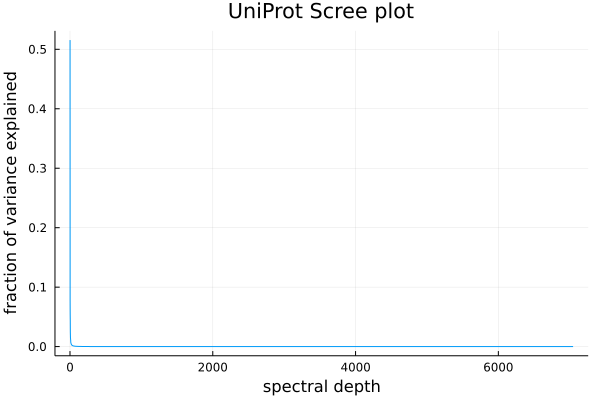

In [3]:
plot(uniprot.uns["SVs"].^2 ./ sum(uniprot.uns["SVs"].^2), 
    title="UniProt Scree plot", 
    ylabel="fraction of variance explained",
    xlabel="spectral depth",
    label="",
    )

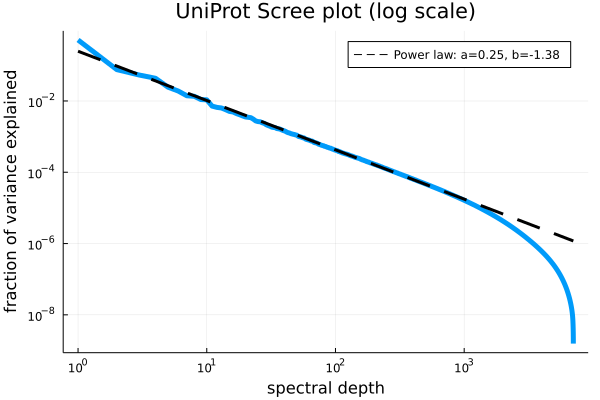

In [102]:

svs = uniprot.uns["SVs"]
y = svs.^2 ./ sum(svs.^2)
plot(svs.^2 ./ sum(svs.^2), 
    title="UniProt Scree plot (log scale)", 
    ylabel="fraction of variance explained",
    xlabel="spectral depth",
    scale=:log10,
    linewidth=5,
    xticks=[1, 10, 100, 1000],
    label="",
    )
a, b = power_fit(1:1000, y[1:1000])
plot!(x->(a*x^b), 1, 7047, lw=3, scale=:log10,
    label="Power law: a=$(round(a, digits=2)), b=$(round(b, digits=2))",
    # label="",
    c=:black,
    linestyle=:dash)

In [98]:
pdir = plotsdir("UP7047extra")
mkdir(pdir)

"/Users/ben/projects/Doran_etal_2022/plots/UP7047extra"

In [103]:
savefig(joinpath(pdir, "UP7047_explainedvariance.pdf"))

In [15]:
occursin.("obeum", biobank.obs.species) |> findall

8-element Vector{Int64}:
  76
  77
  81
 111
 117
 270
 357
 626

In [16]:
uniprot.obsm |> keys

KeySet for a Muon.AlignedMapping{Tuple{1 => 1}, String, AnnData} with 1 entry. Keys:
  "LSVs"

In [18]:
b_obeum_idxs = occursin.("obeum", biobank.obs.species) |> findall

8-element Vector{Int64}:
  76
  77
  81
 111
 117
 270
 357
 626

In [23]:
uhatcombined = vcat(
    uniprot.obsm["LSVs"][:,:],
    biobank["oggs"].obsm["inferredLSVs_UP7047"][:, :])

7720×7047 Matrix{Float64}:
 -0.0114586    -0.0216582     0.019895     …  -0.00343279    0.000169521
 -0.00767793   -0.00636277   -0.0131315       -0.000434615   0.000610293
 -0.0130113    -0.00435805   -0.0099335       -0.000182124   0.00380136
 -0.000602711  -0.000988808   0.000752653      0.0886084    -0.0722487
 -0.00206376   -0.0033936    -0.00111579      -0.00422126   -0.000817393
 -0.0114336     0.00822375   -0.00379274   …  -0.00301883    0.00110319
 -0.0227615     0.0193921    -0.002939         0.001856      0.000376359
 -0.0115215    -0.0114664    -0.00368027      -0.00593608   -0.00406709
 -0.00607869   -0.00275552   -0.00193346       0.00147964   -0.000988248
 -0.00917458   -0.00687051   -0.0125918        0.0025059    -0.00064466
  ⋮                                        ⋱   ⋮            
 -0.00895884   -0.0207339     0.0178657        0.106219     -0.317428
 -0.00903688   -0.0208161     0.0180687        0.118437     -0.345223
 -0.0129656    -0.0307315     0.027649        -0

In [20]:
using SPI

In [ ]:
combineddistances = calc_spi_mtx(uhatcombined, uniprot.uns["SVs"], getintervals(uniprot.uns["SVs"]));

In [27]:
using MAT
matwrite(
    datadir("exp_pro", "BB673", "UPvsBBdists.mat"),
    Dict("dists"=>combineddistances ./ 10117)
)

In [29]:
UPvsBBspimtx = matread(datadir("exp_pro", "BB673", "UPvsBBdists.mat"))["dists"];

In [118]:
establishedUPtaxa = findall(.!occursin.("sp.", uniprot.obs.Species));

In [119]:
uniprot.obs.Species[establishedUPtaxa]

5053-element Vector{String}:
 "Mangrovibacterium diazotrophicum"
 "Halomonas aestuarii"
 "Mycoplasma alkalescens"
 "Bathymodiolus septemdierum thioautotrophic gill symbiont"
 "Conexibacter woesei"
 "Acidibacillus sulfuroxidans"
 "Ferruginivarius sediminum"
 "Flavobacteriaceae bacterium MAR_2010_188"
 "Dialister invisus CAG:218"
 "Frankia alni"
 ⋮
 "Flavihumibacter solisilvae"
 "Lachnospiraceae bacterium RM5"
 "bacterium HR18"
 "Syntrophobacter fumaroxidans"
 "Vibrio tapetis"
 "Gordonia araii"
 "Biostraticola tofi"
 "Camelimonas lactis"
 "Aestuariisphingobium litorale"

In [120]:
predictions = UPvsBBspimtx[1:7047, 7048:end];
@show size(predictions);

size(predictions) = (7047, 673)


In [82]:
b_obeum_idxs = occursin.("obeum", biobank.obs.species) |> findall
r_gnavus_idxs = occursin.("gnavus", biobank.obs.species) |> findall
b_vulgatus_idxs = occursin.("vulgatus", biobank.obs.species) |> findall
b_uniformis_idxs = occursin.("thetaiotaomicron", biobank.obs.species) |> findall
bacteroides_idxs = occursin.("bacteroides", biobank.obs.species) |> findall

21-element Vector{Int64}:
 390
 391
 392
 393
 394
 395
 396
 398
 399
 400
   ⋮
 403
 405
 406
 407
 408
 409
 429
 431
 433

In [121]:
nneighbors = mapslices(x->sortperm(x)[1:5], predictions[establishedUPtaxa, :], dims=1)

5×673 Matrix{Int64}:
 4133   196   196  4961  1608  1608  …  3653   672  1703   196  3653   672
 3158  2758  2758  2359  3158  3158     2359  2359  1608  2758  2359  2359
 3605  3160  2359   178   178   178      178  4015    63   178   178  4015
 2359  3326  3160  4015  2359  2359     3326  4130  1249  2359  3326   178
 4015  2359  2145  2145  4875  4875     3453  2145  4961  4591  3453  4903

In [122]:
predictedspecies = mapslices(idx->uniprot.obs[establishedUPtaxa, :][idx, :Species], nneighbors, dims=1)[1,:] |> 
    x->split.(x, " ") |>
    x->getindex.(x, 2)
speciesaccuracy = mean(occursin.(predictedspecies, biobank.obs.species))


0.5349182763744428

In [123]:
predictedgenus = mapslices(idx->uniprot.obs[establishedUPtaxa, :][idx, :Genus], nneighbors, dims=1)[1,:]
genusaccuracy = mean(occursin.(predictedgenus, biobank.obs.genus))

0.6790490341753344

In [124]:
predictedfamily = mapslices(idx->uniprot.obs[establishedUPtaxa, :][idx, :Family], nneighbors, dims=1)[1,:]
familyaccuracy = mean(occursin.(predictedfamily, biobank.obs.family))

0.711738484398217

In [125]:
predictedorder = mapslices(idx->uniprot.obs[establishedUPtaxa, :][idx, :Order], nneighbors, dims=1)[1,:]
orderaccuracy = mean(occursin.(predictedorder, biobank.obs.order))

0.5319465081723626

In [126]:
predictedclass = mapslices(idx->uniprot.obs[establishedUPtaxa, :][idx, :Class], nneighbors, dims=1)[1,:]
classaccuracy = mean(occursin.(predictedclass, biobank.obs.class))

0.9034175334323923

In [127]:
predictedphylum = mapslices(idx->uniprot.obs[establishedUPtaxa, :][idx, :Phylum], nneighbors, dims=1)[1,:]
phylumaccuracy = mean(occursin.(predictedphylum, biobank.obs.phylum))

0.9197622585438335

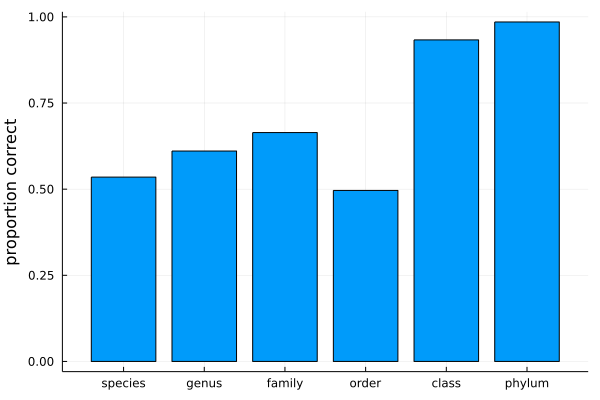

In [101]:
bar([
    speciesaccuracy,
    genusaccuracy,
    familyaccuracy,
    orderaccuracy,
    classaccuracy,
    phylumaccuracy,
], 
xticks=(1:6, ["species", "genus", "family", "order", "class", "phylum"]),
label="",
ylabel="proportion correct"
)

In [67]:
countmap(biobank.obs.species) |> values |> x->map(≥(10), x) |> count

21

In [131]:
(uniprot[:, "COG1344"].X[:,:][:] .> 0.0) |> count

3392